## Structural Analysis

In [1]:
import multidms
import pickle

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import shutil
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBList import PDBList
from Bio.PDB.DSSP import DSSP
from statannotations.Annotator import Annotator

In [4]:
import os
from functools import reduce
from itertools import combinations
from collections import defaultdict

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import jax

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

In [5]:
# plt.rcParams.keys()

In [6]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [7]:
FIG_OUTDIR = "../results/manuscript_figures/"
OUTDIR = "../results/spike_structure_analysis/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

These models were fit with [this version](https://github.com/matsengrp/multidms/commit/4c88f16a13bc910f30aea0394da70373ea87e8e6) of multidms - and thus in the future if the object SHA changes in newer versions pickle binaries will not load unless rolled back to this version

In [8]:
model_set = "../results/model-ch-sig-I-act"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.MultiDmsData object at 0x7f0675...,1,0.0,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.944888810776554, 0.8002181582519432, 0.7401...",<multidms.model.MultiDmsModel object at 0x7ef4...,0
1,<multidms.data.MultiDmsData object at 0x7f0675...,1,0.0,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9380562301362928, 0.7859858644923466, 0.719...",<multidms.model.MultiDmsModel object at 0x7ef4...,1
2,<multidms.data.MultiDmsData object at 0x7f0675...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9449509844610131, 0.801543010059766, 0.7403...",<multidms.model.MultiDmsModel object at 0x7ef4...,0
3,<multidms.data.MultiDmsData object at 0x7f0675...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.939339875770355, 0.7871014657254978, 0.7222...",<multidms.model.MultiDmsModel object at 0x7ef4...,1
4,<multidms.data.MultiDmsData object at 0x7f0675...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9590313547627343, 0.8144916915121373, 0.757...",<multidms.model.MultiDmsModel object at 0x7f06...,0


**Note** When evaluting inferred parameters from these model fits we choose a "times seen threshold" which is essentially the number of genetic backgrounds a mutation must be seen in across all experimental conditions within a single model fit

In [9]:
# Seen at least once in each homolog
times_seen_threshold = 1

In [10]:
# The column name in the models df above denoting where the binary model is saved
model_name = "model_30000"

In [11]:
# The chosen lasso weight for optimal results
chosen_model_penalty = 5e-5

**Note** We will merge the param results from replicate fits for the chosen model penalty. By choosing `how = 'outer'` We keep all mutations from both replicates so long as they each satify the times seen threshold in their respective fit. This means there will be some missing data on both sides

In [12]:
chosen_replicate_models = models.query("λ_lasso_shift == @chosen_model_penalty")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates.head()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.240629,-2.365959,-1.803294,0.030702,0.000000,0.015351,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.194236,-0.136035,-0.165136,-0.000000,0.000000,0.000000,0.0,-0.000037,-0.000018
A1015T,A,1015.0,T,-1.828467,-1.701370,-1.764919,0.000000,1.490752,0.745376,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.209478,-4.209478,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.807699,NaN,-0.807699,0.000000,NaN,0.000000,0.0,NaN,0.000000


In [13]:
! ls ../results

Attic		    no_ch_no_sp  reference_comparison
manuscript_figures  pdb7tf8.ent  shifts_by_site.csv
model-ch-sig-I-act  pdb7tf8.pdb  site_map.csv
naive_approach	    pdb7tl9.ent  spike_structure_analysis
nbr_score_df.csv    pdb7tl9.pdb


In [14]:
pdbl = PDBList()
pdbl.retrieve_pdb_file("7tl9", pdir=f'{OUTDIR}/', file_format='pdb')
shutil.copy(f'{OUTDIR}/pdb7tl9.ent', f'{OUTDIR}/pdb7tl9.pdb')

'../results/spike_structure_analysis//pdb7tl9.pdb'

In [15]:
parser = PDBParser()
structure = parser.get_structure("7tl9", f"{OUTDIR}/pdb7tl9.ent")

/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 26146.
  warnings.warn(
/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 26272.
  warnings.warn(
/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 26328.
  warnings.warn(


In [16]:
! which mkdssp

/home/jgallowa/miniconda3/envs/multidms/bin/mkdssp


In [17]:
model = structure[0]
dssp = DSSP(model, f'{OUTDIR}/pdb7tl9.pdb', dssp='mkdssp', acc_array='Wilke')

In [18]:
dssp

In [19]:
# relative solvent accessibility 
rsa_dict = {
    key : []
    for key in ['res_n', 'rsa']
}
residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
for res in residues:
    full_id = res.get_full_id()
    res_n = ''.join(map(str, full_id[3][1:])).strip()
    chain = full_id[2]
    res_id = res.get_id()
    res_dssp = dssp[(chain, res_id)]
    rsa = res_dssp[3]
    if not res_n.isnumeric():
        continue
    rsa_dict['res_n'].append(int(res_n))
    rsa_dict['rsa'].append(float(rsa))

rsa_df = pd.DataFrame(rsa_dict)

In [20]:
rsa_df

,res_n,rsa
0,27,0.589147
1,28,0.615970
2,29,0.063953
3,30,0.292308
4,31,0.000000
...,...,...
3069,1143,0.327044
3070,1144,0.354260
3071,1145,0.308458
3072,1146,0.652850


In [21]:
omicron_name_map = {c:c.replace("Omicron_", "") for c in mut_df_replicates.columns if "Omicron" in c}
mut_df_replicates.rename(omicron_name_map, axis =1, inplace=True)
mut_df_replicates

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_BA2,1_S_BA2,avg_S_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.240629,-2.365959,-1.803294,0.030702,0.000000,0.015351,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.194236,-0.136035,-0.165136,-0.000000,0.000000,0.000000,0.0,-0.000037,-0.000018
A1015T,A,1015.0,T,-1.828467,-1.701370,-1.764919,0.000000,1.490752,0.745376,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.209478,-4.209478,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.807699,NaN,-0.807699,0.000000,NaN,0.000000,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Y917F,Y,917.0,F,-0.292854,-0.220422,-0.256638,0.000000,0.000000,0.000000,0.0,-0.000000,0.000000
Y917H,Y,917.0,H,-3.455611,-2.315981,-2.885796,0.000000,0.000000,0.000000,0.0,-0.000000,0.000000
Y917N,Y,917.0,N,-2.435212,NaN,-2.435212,0.000000,NaN,0.000000,0.0,NaN,0.000000


In [22]:
same_fx = lambda x: x[0] if np.all(x == x[0]) else -1
cols_to_collapse = [col for col in mut_df_replicates.columns if "avg_" in col]
cols_to_collapse.extend(['sites']) #, 'BA1_wt', 'BA2_wt', 'Delta_wt', 'is_BA2_wt', 'is_Delta_wt'])
shifts_by_site = mut_df_replicates[cols_to_collapse].groupby("sites").agg(
    max_abs_S_BA2 = ('avg_S_BA2', lambda x: np.max(np.abs(x))),
    max_abs_S_Delta = ('avg_S_Delta', lambda x: np.max(np.abs(x))),
    
    mean_abs_S_BA2 = ('avg_S_BA2', lambda x: np.mean(np.abs(x))),
    mean_abs_S_Delta = ('avg_S_Delta', lambda x: np.mean(np.abs(x))),
    
    mean_S_BA2 = ('avg_S_BA2', np.mean),
    mean_S_Delta = ('avg_S_Delta', np.mean),
    
    sum_S_BA2 = ('avg_S_BA2',  np.sum),
    sum_S_Delta = ('avg_S_Delta', np.sum),

#     BA2_wt=('BA2_wt', same_fx),
#     Delta_wt=('Delta_wt', same_fx),
#     is_BA2_wt=('is_BA2_wt', same_fx),
#     is_Delta_wt=('is_Delta_wt', same_fx)
)
# assert -1 not in shifts_by_site.Delta_wt
# # assert -1 not in shifts_by_site.BA1_wt
# assert -1 not in shifts_by_site.BA2_wt
shifts_by_site

,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta
sites,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.101169,0.000057,0.025292,0.000014,-0.025292,-0.000014,-0.101169,-0.000057
3.0,0.110149,0.081638,0.036175,0.013606,0.032394,0.013606,0.194364,0.081638
4.0,0.061520,0.117634,0.023644,0.042836,-0.023644,-0.035587,-0.070931,-0.106760
5.0,0.674212,0.278434,0.078759,0.077590,0.040040,-0.075968,0.720711,-1.367432
...,...,...,...,...,...,...,...,...
1248.0,0.043042,0.170719,0.016369,0.091856,-0.002021,0.047531,-0.012128,0.285185
1249.0,0.034893,0.057105,0.012851,0.019018,0.006072,-0.014249,0.036431,-0.085495
1250.0,0.059849,0.123525,0.024961,0.029137,-0.007862,0.029137,-0.055031,0.203961


In [23]:
# Add non-identical flags to shifts_by_site
rep0_model = chosen_replicate_models.query("replicate == 0")[model_name].values[0]
rep1_model = chosen_replicate_models.query("replicate == 1")[model_name].values[0]
for homolog in ["Delta","Omicron_BA2"]:
    nis_df = rep0_model.data.non_identical_sites[homolog]
    
    # assert our replicate model's inferred the same n.i.s's
    assert nis_df.equals(
        rep1_model.data.non_identical_sites[homolog]
    )
    nis = nis_df.index.values
    hn = homolog if homolog == "Delta" else "BA2"
    shifts_by_site[f"is_{hn}_nis"] = [True if s in nis else False for s in shifts_by_site.index.values]
shifts_by_site

,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,is_Delta_nis,is_BA2_nis
sites,,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False
2.0,0.101169,0.000057,0.025292,0.000014,-0.025292,-0.000014,-0.101169,-0.000057,False,False
3.0,0.110149,0.081638,0.036175,0.013606,0.032394,0.013606,0.194364,0.081638,False,False
4.0,0.061520,0.117634,0.023644,0.042836,-0.023644,-0.035587,-0.070931,-0.106760,False,False
5.0,0.674212,0.278434,0.078759,0.077590,0.040040,-0.075968,0.720711,-1.367432,False,False
...,...,...,...,...,...,...,...,...,...,...
1248.0,0.043042,0.170719,0.016369,0.091856,-0.002021,0.047531,-0.012128,0.285185,False,False
1249.0,0.034893,0.057105,0.012851,0.019018,0.006072,-0.014249,0.036431,-0.085495,False,False
1250.0,0.059849,0.123525,0.024961,0.029137,-0.007862,0.029137,-0.055031,0.203961,False,False


In [24]:
shifts_by_site.to_csv(f"{model_set}/shifts_by_site.csv", index=True)

In [25]:
shifts_by_site = pd.read_csv(f"{model_set}/shifts_by_site.csv", index_col=0).reset_index()
shifts_by_site

,sites,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,is_Delta_nis,is_BA2_nis
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False
1,2.0,0.101169,0.000057,0.025292,0.000014,-0.025292,-0.000014,-0.101169,-0.000057,False,False
2,3.0,0.110149,0.081638,0.036175,0.013606,0.032394,0.013606,0.194364,0.081638,False,False
3,4.0,0.061520,0.117634,0.023644,0.042836,-0.023644,-0.035587,-0.070931,-0.106760,False,False
4,5.0,0.674212,0.278434,0.078759,0.077590,0.040040,-0.075968,0.720711,-1.367432,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1230,1248.0,0.043042,0.170719,0.016369,0.091856,-0.002021,0.047531,-0.012128,0.285185,False,False
1231,1249.0,0.034893,0.057105,0.012851,0.019018,0.006072,-0.014249,0.036431,-0.085495,False,False
1232,1250.0,0.059849,0.123525,0.024961,0.029137,-0.007862,0.029137,-0.055031,0.203961,False,False
1233,1251.0,0.042119,0.243781,0.005265,0.087776,0.005265,-0.087776,0.042119,-0.702206,False,False


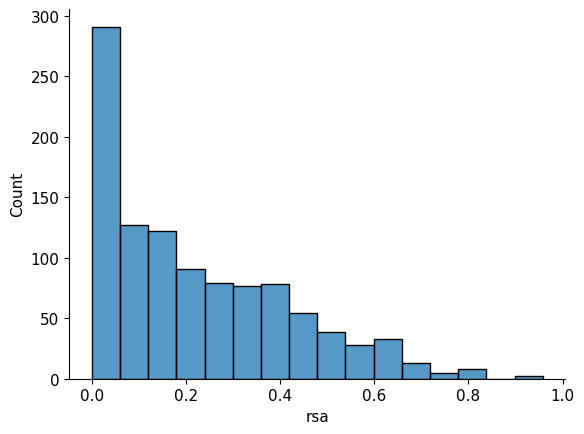

In [26]:
# For each site, take the mean RSA across all chains
rsa_df = rsa_df.groupby(['res_n']).mean()
rsa_df.reset_index(inplace=True)
assert len(rsa_df) == len(set(rsa_df['res_n']))

# Merge into dataframe with sitewise shift summary stats
if 'rsa' not in shifts_by_site.columns.values:
    shifts_by_site = shifts_by_site.merge(rsa_df, left_on='sites', right_on='res_n', how='left')

sns.histplot(rsa_df['rsa'])
sns.despine()
plt.show()

<Axes: xlabel='rsa', ylabel='max_abs_S_Delta'>

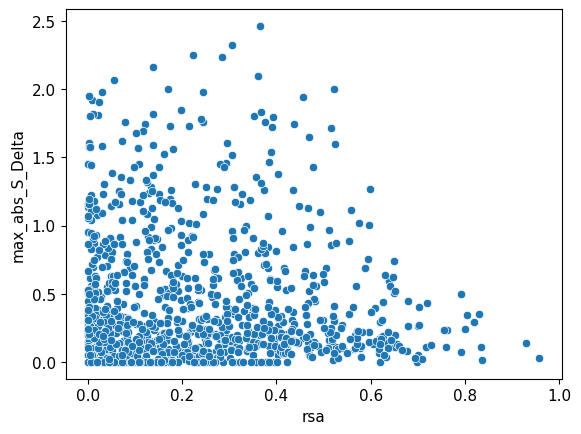

In [27]:
sns.scatterplot(x='rsa', y='max_abs_S_Delta', data=shifts_by_site)

In [28]:
# shifts_by_site

In [29]:
# metric_prefix = 'max_abs_S'

# def group_site(metric):
#     if metric < 0.1:
#         return '0.0-0.1'
#     elif metric < 0.2:
#         return '0.1-0.2'
#     elif metric < 0.3:
#         return '0.2-0.3'
#     elif metric < 0.4:
#         return '0.3-0.4'
#     else:
#         return '>0.4'

# (fig, axs) = plt.subplots(
#     ncols=2, sharex=True, sharey=True,
#     figsize=[8,4]
# )
# for (i, homolog) in enumerate(['BA2', 'Delta']):
# #     metric = f'{metric_prefix}_{homolog}_cons'
#     metric = f'{metric_prefix}_{homolog}'
#     print(metric)
#     shifts_by_site['group'] = shifts_by_site['rsa'].apply(lambda x: group_site(x))
#     group_order = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '>0.4']
#     sns.boxplot(
#         x=metric, y='group', data=shifts_by_site,
#         order=group_order,
#         ax=axs[i], #showfliers=False,
#         color='0.5'
#     )
#     axs[i].set(
#         title=homolog.replace('Omicron_', ''),
#         xlabel=''
#     )
#     axs[i].grid()
    
# xlabel = 'max. abs. shift at site'
# fig.text(0.565, -0.02, xlabel, ha='center')
# axs[0].set(ylabel='RSA of residue')
# axs[1].set(ylabel='')
# plt.tight_layout()
# sns.despine()
# plt.show()

In [30]:
# Get a list of residues, ignorning heteroatoms
residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
res_ns = []
res_ids = []
for res in residues:
    full_id = res.get_full_id()
    chain = full_id[2]
    res_n = ''.join(map(str, full_id[3][1:])).strip()
    if (res_n not in res_ns) and chain == 'A':
        res_ns.append(res_n)
    res_ids.append(f'{chain}_{res_n}')

In [31]:
# Compute a distance matrix between all pairs of C-alpha carbons
dist_dict = {
    key : []
    for key in ['res_n', 'res_id'] + res_ids
}
for res_i in residues:
    full_id_i = res_i.get_full_id()
    chain_i = full_id_i[2]
    res_n_i = ''.join(map(str, full_id_i[3][1:])).strip()
    dist_dict['res_n'].append(res_n_i)
    dist_dict['res_id'].append(f'{chain_i}_{res_n_i}')
    for res_j in residues:
        full_id_j = res_j.get_full_id()
        chain_j = full_id_j[2]
        res_n_j = ''.join(map(str, full_id_j[3][1:])).strip()
        xyz_i = res_i["CA"].get_coord()
        xyz_j = res_j["CA"].get_coord()
        d = np.linalg.norm(xyz_j-xyz_i)
        dist_dict[f'{chain_j}_{res_n_j}'].append(d)
dist_df = pd.DataFrame(dist_dict)

In [32]:
dist_df

,res_n,res_id,A_27,A_28,A_29,A_30,A_31,A_32,A_33,A_34,...,C_1138,C_1139,C_1140,C_1141,C_1142,C_1143,C_1144,C_1145,C_1146,C_1147
0,27,A_27,0.000000,3.811378,7.066604,10.724298,12.775757,15.995064,19.204714,18.059219,...,111.486176,112.094078,114.077385,115.041245,117.297478,120.138023,120.388802,120.366440,123.270622,125.427475
1,28,A_28,3.811378,0.000000,3.792945,7.113520,9.232011,12.394494,15.648566,14.825809,...,107.984886,108.616722,110.575645,111.586060,113.856323,116.660995,116.926308,116.953598,119.845879,121.985664
2,29,A_29,7.066604,3.792945,0.000000,3.791088,6.453536,9.112085,12.574587,12.103994,...,104.965385,105.670792,107.688446,108.741814,110.950180,113.757462,114.103615,114.116539,116.956192,119.151108
3,30,A_30,10.724298,7.113520,3.791088,0.000000,3.806618,5.562723,9.210176,9.552019,...,101.445549,102.181206,104.179802,105.282890,107.498726,110.270241,110.638107,110.698540,113.520889,115.703545
4,31,A_31,12.775757,9.232011,6.453536,3.806618,0.000000,3.854705,6.462251,6.005359,...,101.215691,102.048409,104.004578,105.236839,107.461861,110.143196,110.571861,110.745842,113.519531,115.676926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,1143,C_1143,120.138023,116.660995,113.757462,110.270241,110.143196,106.533920,105.164299,108.633011,...,10.400323,8.300558,6.408051,5.870679,3.876984,0.000000,3.810018,5.291936,5.008859,6.659175
3079,1144,C_1144,120.388802,116.926308,114.103615,110.638107,110.571861,107.008766,105.709282,109.216736,...,12.961762,10.062057,7.450271,5.487663,5.370954,3.810018,0.000000,3.809529,5.370581,5.337458
3080,1145,C_1145,120.366440,116.953598,114.116539,110.698540,110.745842,107.165985,105.970909,109.512878,...,13.562173,10.486953,9.130998,6.117291,4.709569,5.291936,3.809529,0.000000,3.817745,5.496093
3081,1146,C_1146,123.270622,119.845879,116.956192,113.520889,113.519531,109.908821,108.655510,112.167007,...,14.363069,12.058798,10.849333,8.840470,6.136176,5.008859,5.370581,3.817745,0.000000,3.822588


In [33]:
# First, collapse rows by site (ignoring chain),
# taking the min value across common entries
min_dist_df = dist_df.groupby('res_n').min()
min_dist_df.index.name = None
del min_dist_df['res_id']

# Then, transpose the dataframe and do that same
# as above
min_dist_df = min_dist_df.T
min_dist_df['res_n'] = min_dist_df.apply(
    lambda row: row.name[2:],
    axis=1
)
min_dist_df = min_dist_df.groupby('res_n').min()
print(len(min_dist_df.columns.values), len(min_dist_df.index))
#min_dist_df.reset_index(inplace=True)
min_dist_df.head()

1050 1050


,100,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,990,991,992,993,994,995,996,997,998,999
res_n,,,,,,,,,,,,,,,,,,,,,
100,0.000000,57.269909,58.147030,60.695450,58.111557,60.520302,61.691601,61.780830,61.046352,63.394779,...,51.363022,54.775097,55.140244,54.476303,54.531651,57.047848,55.383244,55.728683,57.875916,57.077015
1000,57.269909,0.000000,3.819779,5.389774,4.914857,6.142662,8.594710,9.810758,10.569769,12.350356,...,15.127206,14.059226,12.457101,10.361587,9.917969,8.585588,6.091770,5.201756,5.581903,3.804441
1001,58.147030,3.819779,0.000000,3.816221,5.389239,5.022686,6.118761,8.605238,9.833795,10.475564,...,15.863819,14.898405,14.235265,11.921385,10.342891,9.849586,8.445177,5.981167,5.138320,5.423058
1002,60.695450,5.389774,3.816221,0.000000,3.818494,5.357216,4.953300,6.177926,8.644234,9.849512,...,17.989258,16.279930,15.468401,14.054370,12.099788,10.551577,9.880887,8.490767,6.081089,5.108419
1003,58.111557,4.914857,5.389239,3.818494,0.000000,3.809511,5.443557,5.052581,6.264480,8.711477,...,19.667000,18.135782,16.670715,15.049732,14.144258,12.277769,10.497149,9.762023,8.575770,6.147751


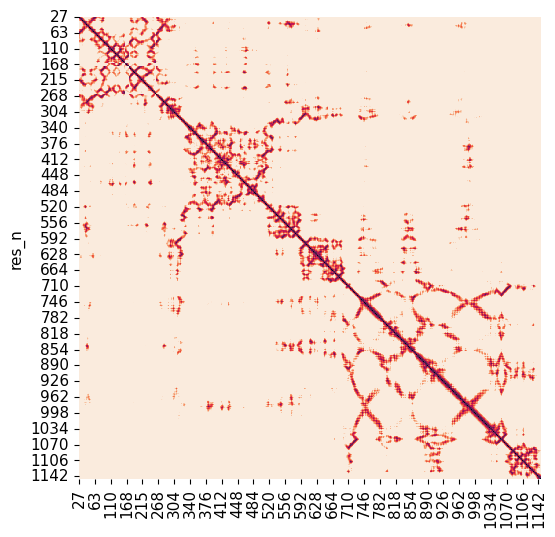

In [34]:
plt.figure(figsize=[6,6])
sns.heatmap(
    min_dist_df.loc[res_ns][res_ns],
    square=True, vmin=0, vmax=20, cbar=False,
)
plt.show()

In [35]:
shifts_by_site["res_n"] = shifts_by_site["sites"].astype(int).astype(str)

In [36]:
shifts_by_site

,sites,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,is_Delta_nis,is_BA2_nis,res_n,rsa
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,1,NaN
1,2.0,0.101169,0.000057,0.025292,0.000014,-0.025292,-0.000014,-0.101169,-0.000057,False,False,2,NaN
2,3.0,0.110149,0.081638,0.036175,0.013606,0.032394,0.013606,0.194364,0.081638,False,False,3,NaN
3,4.0,0.061520,0.117634,0.023644,0.042836,-0.023644,-0.035587,-0.070931,-0.106760,False,False,4,NaN
4,5.0,0.674212,0.278434,0.078759,0.077590,0.040040,-0.075968,0.720711,-1.367432,False,False,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1248.0,0.043042,0.170719,0.016369,0.091856,-0.002021,0.047531,-0.012128,0.285185,False,False,1248,NaN
1231,1249.0,0.034893,0.057105,0.012851,0.019018,0.006072,-0.014249,0.036431,-0.085495,False,False,1249,NaN
1232,1250.0,0.059849,0.123525,0.024961,0.029137,-0.007862,0.029137,-0.055031,0.203961,False,False,1250,NaN
1233,1251.0,0.042119,0.243781,0.005265,0.087776,0.005265,-0.087776,0.042119,-0.702206,False,False,1251,NaN


In [37]:
# Merge per-site data with distance matrix
data = shifts_by_site.merge(
    min_dist_df, on='res_n', how='inner'
)
print(len(shifts_by_site), len(min_dist_df), len(data))

1235 1050 1041


In [38]:
# data.query("")

In [39]:
metric_prefix ="max_abs_S"

In [40]:
# For each site, compute the average metric among
# all neighbors
nbr_dist_cutoff = 8
print(f'Using a neighbor distance cutoff of {nbr_dist_cutoff} Angstroms')
metrics = [col for col in data if metric_prefix in col]
nbr_score_dict = {
    key : []
    for key in ['res_n', 'n_nbrs'] + [f'nbr_{metric}' for metric in metrics]
}
for res_n in list(set(res_ns)):
    nbr_data = data[
        (data[res_n] < nbr_dist_cutoff) &
        (data['res_n'] != res_n)
    ]
    nbr_score_dict['res_n'].append(res_n)
    nbr_score_dict['n_nbrs'].append(len(nbr_data))
    for metric in metrics:
        nbr_score_dict[f'nbr_{metric}'].append(nbr_data[metric].mean())

nbr_score_df = pd.DataFrame(nbr_score_dict)
nbr_score_df = nbr_score_df.merge(data, on='res_n')

Using a neighbor distance cutoff of 8 Angstroms


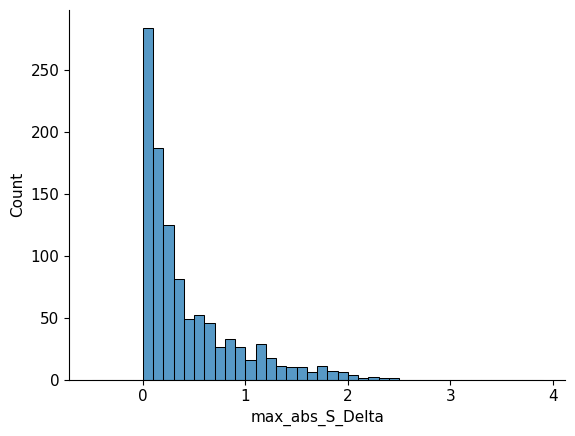

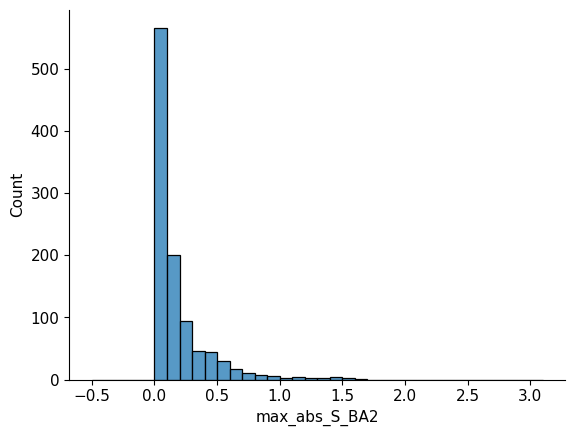

In [41]:
for homolog in ["Delta", "BA2"]:
    bins = np.arange(-0.5, nbr_score_df[f"{metric_prefix}_{homolog}"].max()+1.5, 0.1)
#     print(bins)
    sns.histplot(x=f"{metric_prefix}_{homolog}", data=nbr_score_df, bins=bins)
    sns.despine()
    plt.show()

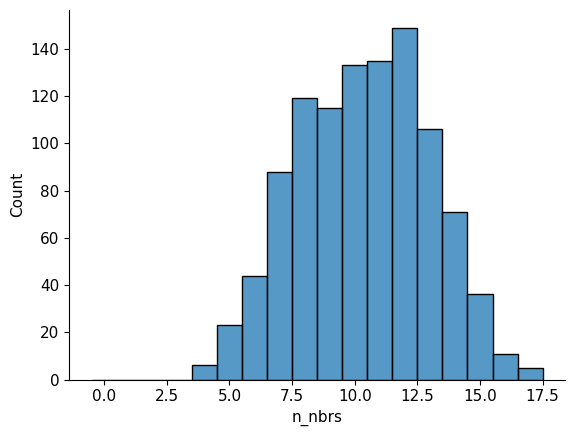

In [42]:
bins = np.arange(-0.5, nbr_score_df['n_nbrs'].max()+1.5, 1)
sns.histplot(x='n_nbrs', data=nbr_score_df, bins=bins)
sns.despine()
plt.show()

In [43]:
# nbr_score_df["is_Delta_nis"] = ~nbr_score_df["is_Delta_wt"]
# nbr_score_df["is_BA2_nis"] = ~nbr_score_df["is_BA2_wt"]

In [44]:
# def group_site_fine(metric):
#     if metric < 0.1:
#         return '0.0-0.1'
#     elif metric < 0.5:
#         return '0.1-0.5'
#     else:
#         return '>0.5'
    
# fine_group_order = ['0.0-0.1', '0.1-0.5', '>0.5']

for homolog in ['BA2', 'Delta']:

#     nbr_score_df[f"fine_group_{homolog}"] = nbr_score_df[
#         f"{metric_prefix}_{homolog}"
#     ].apply(lambda x: group_site_fine(x))
    
    
    # get all nis for condition d
    nis = nbr_score_df.query(f"is_{homolog}_nis == True")["res_n"]
    nbr_score_df[f"dist_nearest_{homolog}_nis"] = nbr_score_df[nis].min(axis=1)

In [45]:
# nbr_score_df[f"fine_group_Delta"].value_counts()

In [46]:
# nbr_score_df[f"fine_group_BA2"].value_counts()

In [47]:
nbr_score_df.sort_values("dist_nearest_BA2_nis", ascending=False)[["res_n", "n_nbrs","dist_nearest_BA2_nis" ]].head()

,res_n,n_nbrs,dist_nearest_BA2_nis
65,1147,4,96.352722
109,1146,5,95.568420
93,1145,6,93.648468
244,1144,7,91.465714
89,1143,8,91.405632


In [62]:
nbr_score_df.to_csv(f"{OUTDIR}/nbr_score_df.csv", index=True)

In [49]:
# from scipy.stats import permutation_test
# def statistic(x, y, axis):
#     return np.median(x, axis=axis) - np.median(y, axis=axis)
# sig = permutation_test(
#     [
#         nbr_score_df.query("fine_group_BA2 == '0.0-0.5'")["nbr_max_abs_S_BA2"].values,
#         nbr_score_df.query("fine_group_BA2 == '>1.0'")["nbr_max_abs_S_BA2"].values
#     ],
#     statistic,
#     n_resamples=100000
# )
# sig

In [50]:
# from statannotations.Annotator import Annotator


In [51]:
nbr_score_df

,res_n,n_nbrs,nbr_max_abs_S_BA2,nbr_max_abs_S_Delta,sites,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,...,992,993,994,995,996,997,998,999,dist_nearest_BA2_nis,dist_nearest_Delta_nis
0,837,10,0.141568,0.567633,837.0,0.000000,0.145272,0.000000,0.044491,0.000000,...,33.906712,30.536947,32.072681,32.489632,28.830441,27.807299,30.408640,29.448332,13.544240,13.544240
1,530,10,0.054682,0.149463,530.0,0.000000,0.191751,0.000000,0.047938,0.000000,...,29.271214,28.367004,32.056770,33.191761,31.005999,32.290359,35.862194,35.654217,13.470410,13.470410
2,285,12,0.211790,0.242499,285.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,34.576839,34.158741,34.367195,34.323154,31.575943,34.275383,35.279503,32.324539,22.660717,22.660717
3,350,13,0.142564,0.674911,350.0,0.000000,1.617692,0.000000,0.808846,0.000000,...,34.710190,35.218018,36.341110,38.922527,40.170071,40.364368,42.321289,43.947510,14.056288,6.662321
4,93,11,0.366000,0.110432,93.0,0.814812,0.198830,0.316095,0.061755,-0.316095,...,45.593983,43.790745,43.780769,46.573330,44.750225,44.327587,46.502842,45.696407,6.806406,6.806406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,1116,10,0.205982,0.536678,1116.0,0.290486,0.754119,0.167311,0.291765,-0.086179,...,94.501045,92.059555,90.776901,89.877312,88.095428,86.231560,85.174149,83.987869,78.480034,32.066940
1037,33,11,0.144295,0.127575,33.0,0.187188,0.518138,0.034586,0.101036,-0.034586,...,41.583210,38.301941,37.958065,40.982250,39.018826,37.235523,39.163483,38.811733,16.507788,16.507788
1038,602,10,0.029032,0.204110,602.0,0.000000,0.070986,0.000000,0.035493,0.000000,...,43.741596,40.138702,39.230839,41.452320,39.232357,36.462429,37.494038,37.031796,30.429482,20.894520
1039,917,12,0.151016,0.744088,917.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,81.706367,79.559586,78.753609,77.513168,75.305756,74.001068,73.188774,71.326637,64.584702,16.363796


In [52]:
# import matplotlib as mpl
# def get_n_cmap_rgba(n, cmap):
#     num_colors = n+1
#     cm = mpl.cm.get_cmap(name=cmap)
#     currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]#[1:]
#     return currentColors

In [53]:
# group_colors = {
#     "Delta" : dict(zip(fine_group_order, get_n_cmap_rgba(3, "Blues"))),
#     "BA2" : dict(zip(fine_group_order, get_n_cmap_rgba(3, "RdPu")))
# }
# group_colors

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.183e-03 U_stat=8.693e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.415e-05 U_stat=2.397e+03


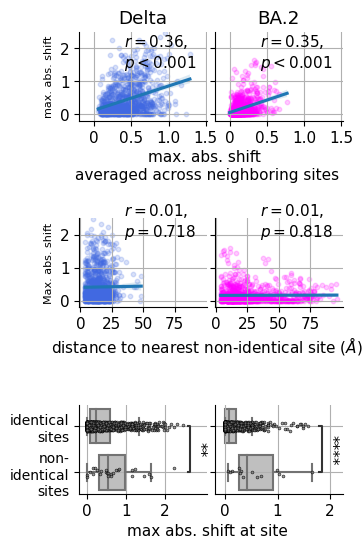

In [54]:
saveas=f"structural_statistics_{metric_prefix}"


fig = plt.figure( figsize=[3.4, 6])
axs = fig.subplot_mosaic(
    """
    bbbBBB
    cccCCC
    dddDDD
    """,
#     height_ratios = [],
#     width_ratios = [],
#     empty_sentinel=".",
    gridspec_kw={
#         "wspace": 0.20,
        "hspace": 1.1,
    }
)

##################
# STRUCTURE IMAGES
##################

# axs["a"].axis("off")
# protein_image = Image.open("../data/delta_structure.jpg")
# axs["a"].imshow(protein_image)

# axs["A"].axis("off")
# protein_image = Image.open("../data/protein_structure.jpg")
# axs["A"].imshow(protein_image)


###############
# MAX V nbr MAX
###############

for homolog, iter_ax in zip(["Delta", "BA2"], ["b", "B"]):
    

#     ax = sns.boxplot(
#         x=f"nbr_{metric_prefix}_{homolog}", 
#         y=f'fine_group_{homolog}',
#         data=nbr_score_df,
#         order=fine_group_order,
#         ax=axs[iter_ax],
#         showfliers=False,
#         orient="h",
#         color='0.75',
#         width=0.75
#     )
#     sns.stripplot(
# #         x=f"nbr_max_abs_S_{homolog}", 
#         x=f"nbr_{metric_prefix}_{homolog}", 
#         y=f'fine_group_{homolog}',
#         data=nbr_score_df,
#         order=fine_group_order,
#         ax=axs[iter_ax],
#         orient="h",
#         palette=group_colors[homolog],  # 'royalblue' if homolog == "Delta" else "magenta",
#         alpha=0.75,
#         size=2,
#         edgecolor="k",
#         linewidth=0.5
#     )

    sns.regplot(
        data = nbr_score_df,
        y = f"{metric_prefix}_{homolog}",
        x = f"nbr_{metric_prefix}_{homolog}",
        ax=axs[iter_ax],
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":10,
            "alpha":0.2,
#             "edgecolor":"k",
#             "linewidth":2
        }
    )

    
    corr, p = pearsonr(
        nbr_score_df[f"nbr_{metric_prefix}_{homolog}"], 
        nbr_score_df[f"{metric_prefix}_{homolog}"]
    )
    p = round(p, 3)
    p = f"p={p}" if p != 0 else "p<0.001"
    axs[iter_ax].annotate(
        f"$r = {corr:.2f}$,\n${p}$", 
        (0.35, 0.6), 
        xycoords="axes fraction", 
        fontsize=11
    )
    

    axs[iter_ax].set_ylim([-0.2, 2.5])
    axs[iter_ax].set_yticks([0, 1,2], labels = [0, 1,2])
    
    axs[iter_ax].set_xlim([-0.2, 1.52])
#     axs[iter_ax].set_xlim([-0.2, 1.52])
    axs[iter_ax].set_xticks([0, 0.5, 1.0, 1.5], labels = [0, 0.5, 1.0, 1.5])
    axs[iter_ax].set_title(homolog if homolog == "Delta" else "BA.2")
    
    if homolog == "Delta":
        xlabel=f'{metric_prefix} \naveraged across neighboring sites'
#         xlabel=f'Mean. abs. shift \naveraged across neighboring sites'
        xlabel=f'max. abs. shift \naveraged across neighboring sites'
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -.33)
        axs[iter_ax].set_ylabel("max. abs. shift", size=8)
#         axs[iter_ax].set_ylabel("Max. abs. shift", size=8)
#         axs[iter_ax].set_ylabel(metric_prefix, size=8)
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
        axs[iter_ax].set_ylabel(None)
        
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()

    

    
#     pairs=[("0.0-0.1", ">0.5")]

#     annotator = Annotator(
#         ax,
#         pairs,
# #         x=f"nbr_max_abs_S_{homolog}", 
#         x=f"nbr_{metric_prefix}_{homolog}", 
#         y=f'fine_group_{homolog}',
#         data=nbr_score_df,
#         order=fine_group_order,
#         orient="h"
#     )
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
#     annotator.apply_and_annotate()


###############
# MAX V nbr MAX
###############



for homolog, iter_ax in zip(["Delta", "BA2"], ["c", "C"]):
    

#     ax = sns.boxplot(
#         x=f"dist_nearest_{homolog}_nis", 
#         y=f'fine_group_{homolog}',
#         data=nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0"),
#         order=fine_group_order,
#         ax=axs[iter_ax],
#         showfliers=False,
#         orient="h",
#         color='0.75',
#         width=0.75
#     )
#     sns.stripplot(
#         x=f"dist_nearest_{homolog}_nis", 
#         y=f'fine_group_{homolog}',
#         data=nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0"),
#         order=fine_group_order,
#         ax=axs[iter_ax],
#         orient="h",
# #         color='royalblue' if homolog == "Delta" else "magenta",
#         palette=group_colors[homolog],  # 'royalblue' if homolog == "Delta" else "magenta",
#         alpha=0.75,
#         size=2,
#         edgecolor="k",
#         linewidth=0.5
#     )

#     scatter_kws["c"] = 'royalblue' if homolog == "Delta" else "magenta"

    sns.regplot(
        data = nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0"),
#         c='royalblue' if homolog == "Delta" else "magenta",
        y = f"{metric_prefix}_{homolog}",
        x = f"dist_nearest_{homolog}_nis",
        ax=axs[iter_ax],
#         scatter_kws = scatter_kws
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":10,
            "alpha":0.2,
#             "edgecolor":"k",
#             "linewidth":2
        }
    )
    corr, p = pearsonr(
        nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0")[f"dist_nearest_{homolog}_nis"], 
        nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0")[f"{metric_prefix}_{homolog}"]
    )
    p = round(p, 3)
    p = f"p={p}" if p != 0 else "p<0.001"
    axs[iter_ax].annotate(
        f"$r={corr:.2f}$,\n${p}$", 
        (0.35, 0.8),
        xycoords="axes fraction", 
        fontsize=11
    )



    axs[iter_ax].set_ylim([-0.2, 2.5])
    axs[iter_ax].set_yticks([0, 1,2], labels = [0, 1,2])
    
    axs[iter_ax].set_xlim([-1, 101])
    axs[iter_ax].set_xticks([0, 25, 50, 75], labels = [0, 25, 50, 75])
    
    
    if homolog == "Delta":
        xlabel = 'distance to nearest non-identical site ($\AA$)'
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -.31)
        axs[iter_ax].set_ylabel(metric_prefix, size=8)
        axs[iter_ax].set_ylabel("Max. abs. shift", size=8)
#         axs[iter_ax].set_ylabel("Mean. abs. shift", size=8)
        
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
        axs[iter_ax].set_ylabel(None)
        
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()
    
#     pairs=[("0.0-0.1", ">0.5")]
# #     pairs=[("0.0-0.5", ">1.0")]

#     annotator = Annotator(
#         ax,
#         pairs,
#         x=f"dist_nearest_{homolog}_nis", 
# #         x=f"nbr_max_abs_S_{homolog}", 
#         y=f'fine_group_{homolog}',
#         data=nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0"),
#         order=fine_group_order,
#         orient="h"
#     )
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
#     annotator.apply_and_annotate()

    
###########################
# NIS V I Site distribution
###########################


for homolog, iter_ax in zip(["Delta", "BA2"], ["d", "D"]):
    
    ax = sns.boxplot(
        y=f"is_{homolog}_nis", 
        x=f"{metric_prefix}_{homolog}",
#         x=f"n_nbrs",
        data=nbr_score_df,
        order=[False, True],
        ax=axs[iter_ax], 
        showfliers=False,
        width=0.75,
        orient="h",
        color='0.75'
    )
    sns.stripplot(
        y=f"is_{homolog}_nis", 
        x=f"{metric_prefix}_{homolog}",
#         x=f"n_nbrs",
        data=nbr_score_df,
        order=[False, True],
        ax=axs[iter_ax],
        orient="h",
        color="0.5", #'royalblue' if homolog == "Delta" else "magenta",
        alpha=0.75,
        size=2,
        edgecolor="k",
        linewidth=0.5
#         marker="o"
    )
    
    axs[iter_ax].set_xlim([-0.2, 2.2])
    axs[iter_ax].set_xticks([0, 1, 2], labels = [0, 1, 2])

    if homolog == "Delta":
        axs[iter_ax].set_yticklabels(["identical\nsites", "non-\nidentical\nsites"], size=10)
        xlabel=f'max abs. shift at site'
#         xlabel=f'Mean abs. shift at site'
#         xlabel=metric_prefix
#         xlabel="# nbrs"
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -.33)
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
    axs[iter_ax].set_ylabel(None)           
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()
    pairs=[(False, True)]

    annotator = Annotator(
        ax,
        pairs,
        y=f"is_{homolog}_nis", 
        x=f"{metric_prefix}_{homolog}",
#         x=f"max_abs_S_{homolog}",
        data=nbr_score_df,
        order=[False, True],
        orient="h"
    )
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
#     annotator.configure(test='Mann-Whitney',  loc='inside')
    annotator.apply_and_annotate()

    
fig.savefig(f"{FIG_OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{FIG_OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

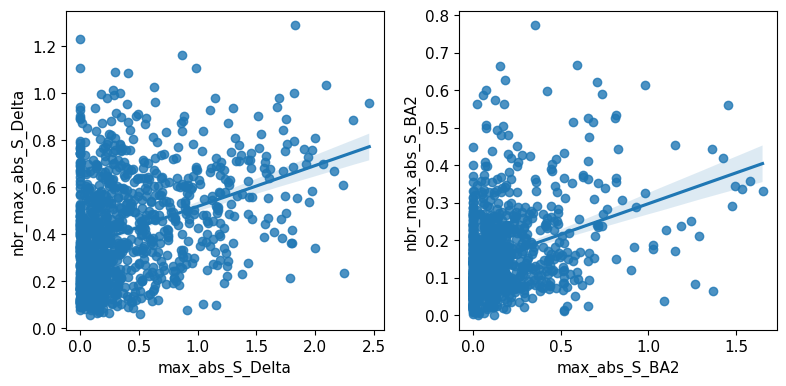

In [55]:
fig, ax = plt.subplots(1,2, figsize=[8, 4])
for i, homolog in enumerate(["Delta", "BA2"]):
    sns.regplot(
        data = nbr_score_df,
        x = f"{metric_prefix}_{homolog}",
        y = f"nbr_{metric_prefix}_{homolog}",
        ax=ax[i]
    )
plt.tight_layout()
plt.show()

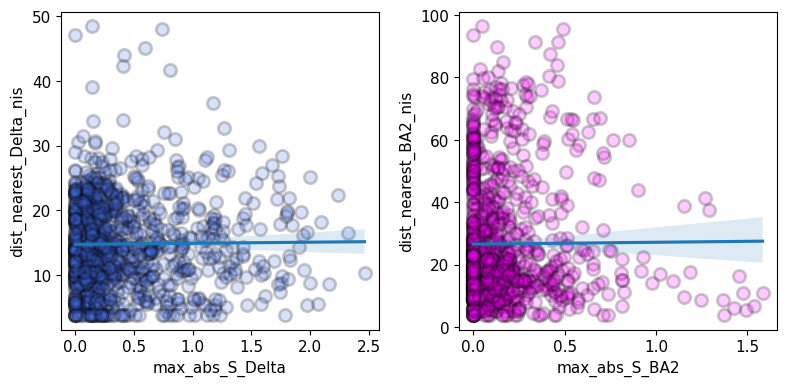

In [56]:
fig, ax = plt.subplots(1,2, figsize=[8, 4])
for i, homolog in enumerate(["Delta", "BA2"]):
    sns.regplot(
        data = nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0"),
        x = f"{metric_prefix}_{homolog}",
        y = f"dist_nearest_{homolog}_nis",
        ax=ax[i],
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":80,
            "alpha":0.2,
            "edgecolor":"k",
            "linewidth":2
        }
    )
plt.tight_layout()
plt.show()

In [57]:
mut_df_replicates

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_BA2,1_S_BA2,avg_S_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.240629,-2.365959,-1.803294,0.030702,0.000000,0.015351,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.194236,-0.136035,-0.165136,-0.000000,0.000000,0.000000,0.0,-0.000037,-0.000018
A1015T,A,1015.0,T,-1.828467,-1.701370,-1.764919,0.000000,1.490752,0.745376,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.209478,-4.209478,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.807699,NaN,-0.807699,0.000000,NaN,0.000000,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Y917F,Y,917.0,F,-0.292854,-0.220422,-0.256638,0.000000,0.000000,0.000000,0.0,-0.000000,0.000000
Y917H,Y,917.0,H,-3.455611,-2.315981,-2.885796,0.000000,0.000000,0.000000,0.0,-0.000000,0.000000
Y917N,Y,917.0,N,-2.435212,NaN,-2.435212,0.000000,NaN,0.000000,0.0,NaN,0.000000


In [58]:
vc = mut_df_replicates.sites.value_counts()
vc_df = pd.DataFrame({"sites":vc.index.values, "n_muts_at_site":vc.values}).set_index("sites")
vc_df

,n_muts_at_site
sites,
253.0,21
76.0,21
19.0,21
1228.0,21
75.0,21
...,...
993.0,1
997.0,1
338.0,1


In [59]:
is_nis = data.copy()[["sites", "is_Delta_nis", "is_BA2_nis"]].set_index("sites")
is_nis

,is_Delta_nis,is_BA2_nis
sites,,
27.0,False,True
28.0,False,False
29.0,False,False
30.0,False,False
31.0,False,False
...,...,...
1143.0,False,False
1144.0,False,False
1145.0,False,False


In [60]:
df = is_nis.merge(vc_df, left_index=True, right_index=True)
df

,is_Delta_nis,is_BA2_nis,n_muts_at_site
sites,,,
27.0,False,True,8
28.0,False,False,5
29.0,False,False,20
30.0,False,False,8
31.0,False,False,2
...,...,...,...
1143.0,False,False,4
1144.0,False,False,6
1145.0,False,False,1


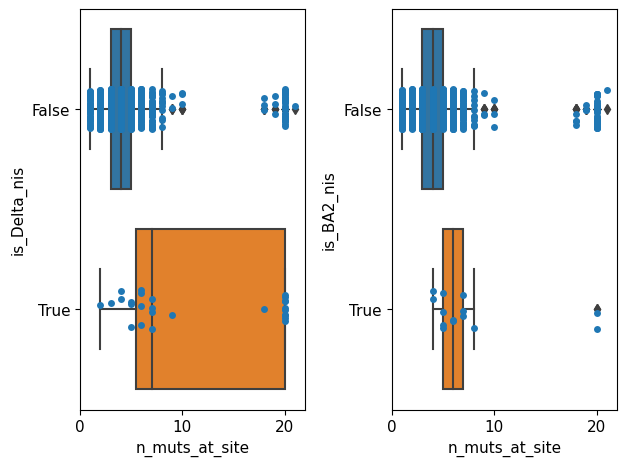

In [61]:
fig, ax  = plt.subplots(1, 2)
for i, homolog in enumerate(["Delta", "BA2"]):
    sns.boxplot(
        x = "n_muts_at_site",
        y = f"is_{homolog}_nis",
        ax = ax[i],
        data=df,
        orient="h"
    )
    sns.stripplot(
        x = "n_muts_at_site",
        y = f"is_{homolog}_nis",
        ax = ax[i],
        data=df,
        orient="h"
    )
plt.tight_layout()
plt.show()